In [ ]:
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
# from keras.layers.convolutional import*
from keras.metrics import categorical_crossentropy

import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
device_name

NameError: ignored

In [ ]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
train_path = '/content/drive/MyDrive/emotion_detection/train'
test_path = '/content/drive/MyDrive/emotion_detection/test'

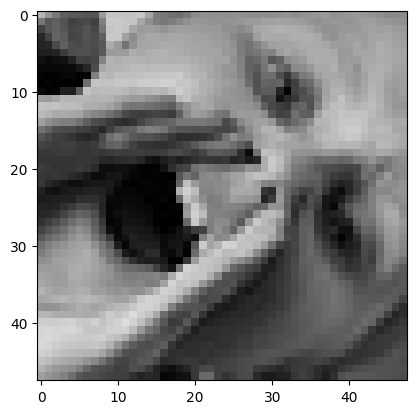

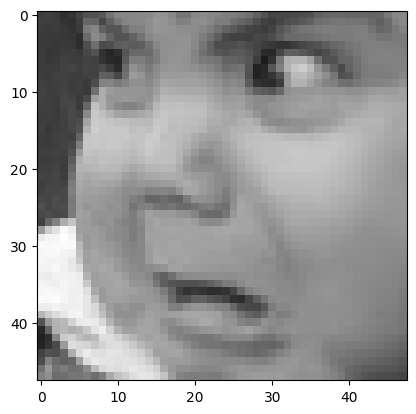

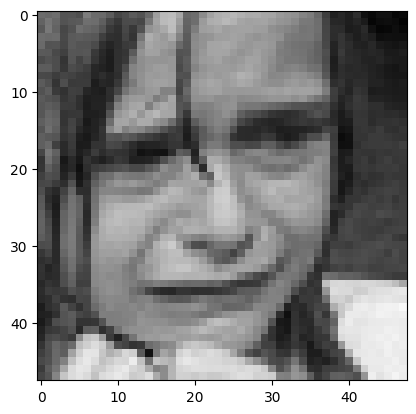

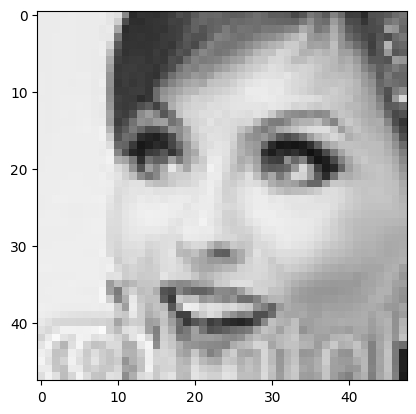

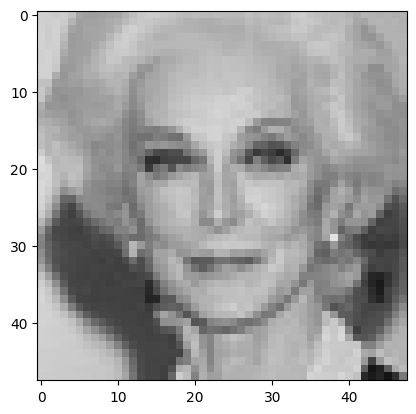

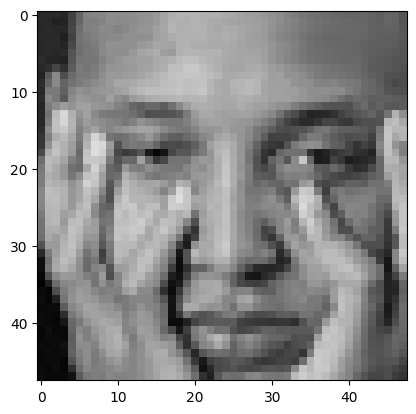

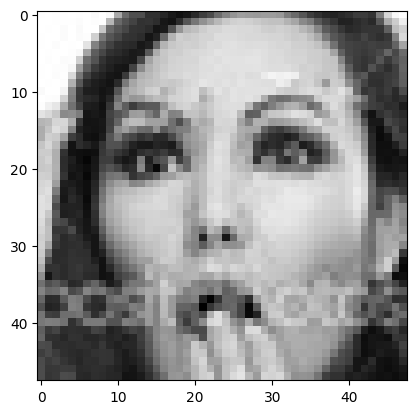

In [ ]:
# display the first image in each category
for emo_class in classes:
  path = os.path.join(train_path, emo_class)
  for img in os.listdir(path):
      img_arr = cv2.imread(os.path.join(path, img))
      plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
      plt.show()
      break # to only show the first image

# Pre-processing

We'll use the pretrained ImageNet model so we know our input must be size 224x224. So we will resize our images.

In [ ]:
# convert all images into 224 x 224

train_ds = []
size = 224

for emo_class in classes:
    path = os.path.join(train_path, emo_class)
    for img in os.listdir(path)[:300]:
      try:
        img_arr = cv2.imread(os.path.join(path, img))
        resized_img = cv2.resize(img_arr, (size, size))
        train_ds.append([resized_img, classes.index(emo_class)])
      except Exception as e:
        pass

In [ ]:
# shuffle the training data
random.shuffle(train_ds)

In [ ]:
# extract features and labels

X = [] # image features
y = [] # labels

for features, label in train_ds:
    X.append(features)
    y.append(label)

# convert X to 4 dimensions (needed for MobileNet)
X = np.array(X).reshape(-1, size, size, 3)

In [ ]:
# normalize the data
X = X/255.0
X.shape

(2100, 224, 224, 3)

In [ ]:
len(train_ds)

2100

In [ ]:
# convert y list to numpy array
Y = np.array(y)
Y.shape

(2100,)

# Model (architecture, transfer learning)

In [ ]:
pre_trained_model = tf.keras.applications.MobileNetV2()
pre_trained_model

14536120/14536120 [==============================] - 0s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
# removing the very last layer from the MobileNet model
base_input = pre_trained_model.layers[0].input
base_output = pre_trained_model.layers[-2].output

base_input, base_output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>)

In [ ]:
# add custom layers to model
output = layers.Dense(len(classes), activation='relu')(base_output)

#layers.Dense(64, activation='relu')(base_output)
ouput = layers.Dense(len(classes), activation='softmax')(output)

In [ ]:
model = keras.Model(
    inputs=base_input,
    outputs=output
)

In [ ]:
model = Sequential([
    #Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3)),
    #MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    Flatten(),
    Dropout(0.4),
    #BatchNormalization(axis=1),
    Dense(len(classes), activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dropout (Dropout)           (None, 93312)             0

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    X,
    Y,
    epochs=30,
    batch_size=16,
    verbose=1,
    validation_split=0.2
)

Epoch 1/30
105/105 [==============================] - 16s 42ms/step - loss: 1.9926 - accuracy: 0.1321 - val_loss: 1.9437 - val_accuracy: 0.1381
Epoch 2/30
105/105 [==============================] - 3s 30ms/step - loss: 1.9216 - accuracy: 0.1935 - val_loss: 1.9352 - val_accuracy: 0.1476
Epoch 3/30
105/105 [==============================] - 3s 31ms/step - loss: 1.8649 - accuracy: 0.2417 - val_loss: 1.9802 - val_accuracy: 0.1286
Epoch 4/30
105/105 [==============================] - 3s 33ms/step - loss: 1.7775 - accuracy: 0.2845 - val_loss: 1.9986 - val_accuracy: 0.1571
Epoch 5/30
105/105 [==============================] - 3s 31ms/step - loss: 1.6927 - accuracy: 0.3238 - val_loss: 2.0652 - val_accuracy: 0.1905
Epoch 6/30
105/105 [==============================] - 3s 30ms/step - loss: 1.6004 - accuracy: 0.3726 - val_loss: 2.1044 - val_accuracy: 0.1571
Epoch 7/30
105/105 [==============================] - 3s 30ms/step - loss: 1.5229 - accuracy: 0.4220 - val_loss: 2.2471 - val_accuracy: 0.202

In [ ]:
image1 = X[0]
resized_image = cv2.resize(img_arr, (224, 224))
resized_image.reshape(-1, size, size, 3) / 255.0

array([[[[0.68627451, 0.68627451, 0.68627451],
         [0.68627451, 0.68627451, 0.68627451],
         [0.68627451, 0.68627451, 0.68627451],
         ...,
         [0.69803922, 0.69803922, 0.69803922],
         [0.69803922, 0.69803922, 0.69803922],
         [0.69803922, 0.69803922, 0.69803922]],

        [[0.68627451, 0.68627451, 0.68627451],
         [0.68627451, 0.68627451, 0.68627451],
         [0.68627451, 0.68627451, 0.68627451],
         ...,
         [0.69803922, 0.69803922, 0.69803922],
         [0.69803922, 0.69803922, 0.69803922],
         [0.69803922, 0.69803922, 0.69803922]],

        [[0.68627451, 0.68627451, 0.68627451],
         [0.68627451, 0.68627451, 0.68627451],
         [0.68627451, 0.68627451, 0.68627451],
         ...,
         [0.69803922, 0.69803922, 0.69803922],
         [0.69803922, 0.69803922, 0.69803922],
         [0.69803922, 0.69803922, 0.69803922]],

        ...,

        [[0.34901961, 0.34901961, 0.34901961],
         [0.34901961, 0.34901961, 0.34901961]

In [ ]:
def predict_using_model(image):

  # pre-processing steps:
  # first, we resize the image
  resized_image = cv2.resize(img_arr, (224, 224))

  # converting input image to 4 dimensions
  converted_image = resized_image.reshape(-1, 224, 224, 3)

  # normalized image
  normalized_image = converted_image / 255.0

  # make prediction
  pred = model.predict(normalized_image)
  predicted_class = classes[np.argmax(pred)]

  return predicted_class



In [ ]:
predict_using_model(image1)

1/1 [==============================] - 0s 42ms/step


'surprise'

In [ ]:
test_path

'/content/drive/MyDrive/emotion_detection/test'